In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fname = "hodograph.csv"
df = pd.read_csv(fname)
x, y, time = df.to_numpy().T

df

,rec_x,rec_y,time
0,-100.0,-100.0,0.237912
1,-80.0,-100.0,0.235332
2,-60.0,-100.0,0.231905
3,-40.0,-100.0,0.230841
4,-20.0,-100.0,0.223027
...,...,...,...
116,20.0,100.0,0.218737
117,40.0,100.0,0.227905
118,60.0,100.0,0.233424
119,80.0,100.0,0.237045


## Решение СЛАУ

In [3]:
A = np.vstack((np.ones(len(x)), x**2 + y**2)).T
params = np.linalg.lstsq(A, time**2, rcond=None)[0]
R=np.sqrt(params)
R_t0=R[0]
R_v = 1/R[1]
print(R_t0, R_v)

0.20066750947645187 1038.911946339758


In [4]:
def f(t0, r, v):
  return np.sqrt(t0**2 + r / v**2)

def dt0(t, t0, r, v):
  F=f(t0, r, v)
  return np.sum(2 * t0 *(F - t) / np.sqrt(F))

#производная по v
def dv(t, t0, r, v):
  F=f(t0, r, v)
  return np.sum(2 * r**2 * (t - F) / (v**3 * F))


In [5]:
def gradient_descent(t0, v, t, r, iter):
  lr_t0 = 0.005
  lr_v = 10

  t0_list = np.zeros(iter)
  v_list = np.zeros(iter)

  for i in range(iter):
    # cтарт шага
    t0_list[i] = t0
    v_list[i] = v
    # обновим веса в направлении антиградиента
    t0 -= (lr_t0 * (iter - i) / iter) * dt0(t, t0, r, v)
    v -= (lr_v * (iter - i) / iter) * dv(t, t0, r, v)
  return t0_list, v_list

In [6]:
t0=0.25
v=1100
r=x**2 + y**2

In [7]:
t0_list, v_list = gradient_descent(t0,v, time , r, 1000)
print(t0_list[-1], v_list[-1])


0.20071517543791717 1041.031122140536


In [21]:
from scipy.optimize import minimize

def objective(p, r, t):
  t0, v = p
  p_t = np.sqrt(t0**2 + r / v**2)
  return np.mean((p_t - t)**2)

result = minimize(objective, (t0,v), args=(r, time), method = 'Powell')
print(result.x[0], result.x[1])

0.20051587646963867 1033.1873827738013


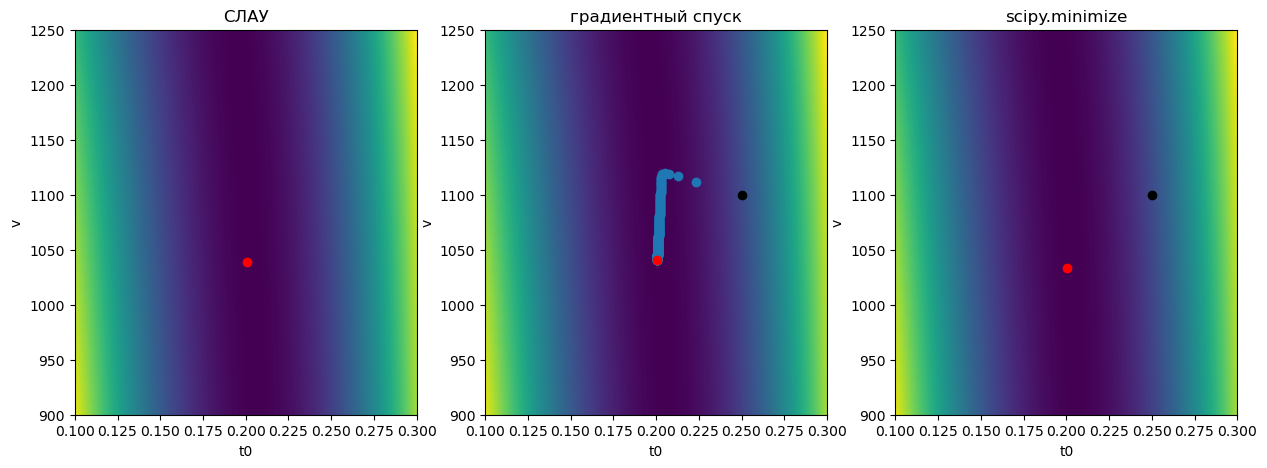

In [22]:
fig, graphs = plt.subplots(1, 3, figsize=(15, 5))

t0_range = np.linspace(0.1, 0.3, 200)
v_range = np.linspace(900, 1250, 200)
heatmap = [[objective((i,j), r, time) for i in t0_range] for j in v_range]


graphs[0].set_title("СЛАУ")
graphs[0].scatter(R_t0, R_v, color="r")

graphs[1].set_title("градиентный спуск")
graphs[1].scatter(t0_list, v_list)
graphs[1].scatter(t0_list[-1], v_list[-1], color="r")
graphs[1].scatter(t0, v, color="k")

graphs[2].set_title("scipy.minimize")
graphs[2].scatter(result.x[0], result.x[1], color="r")
graphs[2].scatter(t0, v, color="k")

for i in graphs:
    im = i.imshow(heatmap, aspect="auto", extent=[t0_range[0], t0_range[-1], v_range[0], v_range[-1]])
    i.set_xlabel("t0")
    i.set_ylabel("v")

